In [3]:
import pickle
import os
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
import matplotlib.dates as mdates
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter

from django.conf import settings

from pathlib import Path

feature_set = ['Active Power', 'Reactive Power', 'Governor speed actual', 'UGB X displacement', 'UGB Y displacement',
    'LGB X displacement', 'LGB Y displacement', 'TGB X displacement',
    'TGB Y displacement', 'Stator winding temperature 13',
    'Stator winding temperature 14', 'Stator winding temperature 15',
    'Surface Air Cooler Air Outlet Temperature',
    'Surface Air Cooler Water Inlet Temperature',
    'Surface Air Cooler Water Outlet Temperature',
    'Stator core temperature', 'UGB metal temperature',
    'LGB metal temperature 1', 'LGB metal temperature 2',
    'LGB oil temperature', 'Penstock Flow', 'Turbine flow',
    'UGB cooling water flow', 'LGB cooling water flow',
    'Generator cooling water flow', 'Governor Penstock Pressure',
    'Penstock pressure', 'Opening Wicked Gate', 'UGB Oil Contaminant',
    'Gen Thrust Bearing Oil Contaminant']

model_array = ["Attention", "DTAAD", "MAD_GAN", "TranAD", "DAGMM", "USAD", "OmniAnomaly"]
with open('model_thr.pickle', 'rb') as handle:
    model_thr = pickle.load(handle)

with open('normalize_2023.pickle', 'rb') as handle:
    normalize_obj = pickle.load(handle)
    min_a, max_a = normalize_obj['min_a'], normalize_obj['max_a']

def normalize3(a, min_a=None, max_a=None):
    if min_a is None: min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return ((a - min_a) / (max_a - min_a + 0.0001)), min_a, max_a

def denormalize3(a_norm, min_a, max_a):
    return a_norm * (max_a - min_a + 0.0001) + min_a


def fetch_between_dates(start_date, end_date, db_name="data.db", table_name="sensor_data"):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT * FROM {table_name} WHERE timestamp BETWEEN ? AND ?
    """, (start_date, end_date))
    
    rows = cursor.fetchall()
    conn.close()

    if not rows:
        return np.array([])
    
    return np.array(rows)

def fetch_last_rows(num_row, db_name="data.db", table_name="sensor_data"):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    cursor.execute(f"""
        SELECT * FROM {table_name} ORDER BY timestamp DESC LIMIT ?
    """, (num_row,))
    
    rows = cursor.fetchall()
    conn.close()

    if not rows:
        return np.array([])
    
    return np.array(rows)

def convert_timestamp(timestamp_str):
    dt = datetime.fromisoformat(timestamp_str)
    return pd.Timestamp(dt.strftime('%Y-%m-%d %H:%M:%S'))

def percentage2severity(value):
    return (
        1 if 0 <= value < 5 else
        2 if 5 <= value < 20 else
        3 if 20 <= value < 40 else
        4 if 40 <= value < 75 else
        5 if 75 <= value <= 100 else
        6
    )
    
def calc_counterPercentage(threshold_percentages):
    counter_feature = {}
    for modex_idx, values_pred in threshold_percentages.items():
        values_pred = dict(sorted(values_pred.items(), key=lambda item: item[1], reverse=True)[:10])
        for name_feat, percentage in values_pred.items():
            if name_feat in counter_feature:
                counter_feature[name_feat]["count"] = counter_feature[name_feat]["count"] + 1
                counter_feature[name_feat]["percentage"] = counter_feature[name_feat]["percentage"] + percentage
            else:
                counter_feature[name_feat] = {"count": 1, "percentage": percentage}

    counter_feature_s1 = dict(sorted(counter_feature.items(), key=lambda item: item[1]['count'], reverse=True)[:10])
    counter_feature_s2 = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['percentage'] // len(model_array), reverse=True))
    #counter_feature_s2_rank = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['count'], reverse=True))

    for key, value in counter_feature_s2.items():
        counter_feature_s2[key]['count'] = (counter_feature_s2[key]['count'] / len(model_array)) * 100
        counter_feature_s2[key]['severity'] = percentage2severity(counter_feature_s2[key]['percentage'] // len(model_array))
        counter_feature_s2[key]['percentage'] = (counter_feature_s2[key]['percentage'] // len(model_array))

    # Find Which Model Have Highest Confidence
    counter_feature_plot = {}
    for index, value in counter_feature_s2.items():
        higher_data = {"model": 0, "percentage": 0}
        for model_idx in threshold_percentages:
            if index in threshold_percentages[model_idx]:
                if higher_data["percentage"] <= threshold_percentages[model_idx][index]:
                    higher_data["model"] = model_idx
                    higher_data["percentage"] = threshold_percentages[model_idx][index]
        
        counter_feature_plot[index] = higher_data['model']

    return counter_feature_s2, counter_feature_plot

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [70]:
end_date = "2021-05-28T05:55:00"
start_date = "2021-01-28T06:10:00"

severity_trending_datas = fetch_between_dates(start_date, end_date, "db/severity_trendings.db", "severity_trendings")
sensor_datas = fetch_between_dates(start_date, end_date, "db/severity_trendings.db", "original_sensor")
    
data_timestamp = sensor_datas[:, 1]
severity_trending_datas = severity_trending_datas[:, 2:].astype(float)
sensor_datas = sensor_datas[:, 2:].astype(float)

window_size = 30
kernel = np.ones(window_size) / window_size

severity_trending_datas = (severity_trending_datas - 0) / (100 - 0 )

for i in range(len(feature_set)):
    severity_trending_datas[:, i] = np.convolve(severity_trending_datas[:, i], kernel, mode='same')

In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis

def extract_time_series_features(x):
    x = np.asarray(x)

    features = {}

    # Basic statistics
    features['mean'] = np.mean(x)
    features['min'] = np.min(x)
    features['max'] = np.max(x)
    features['std'] = np.std(x)
    features['range'] = np.ptp(x)  # max - min
    features['mad'] = np.mean(np.abs(x - np.mean(x)))  # Mean Absolute Deviation
    features['rms'] = np.sqrt(np.mean(x**2))  # Root Mean Square
    features['skewness'] = skew(x)
    features['kurtosis'] = kurtosis(x)

    # Monotonicity (fraction of increasing / decreasing)
    diffs = np.diff(x)
    features['monotonic_increasing'] = np.sum(diffs > 0) / len(diffs)
    features['monotonic_decreasing'] = np.sum(diffs < 0) / len(diffs)

    # Slope (linear trend) and gradient
    if len(x) > 1:
        t = np.arange(len(x))
        slope = np.polyfit(t, x, 1)[0]
        features['slope'] = slope
    else:
        features['slope'] = np.nan

    features['gradient_mean'] = np.mean(np.gradient(x))

    df = pd.DataFrame([features])
    return features


In [83]:
overlap = 0.2
window_size = 1492
step_size = int(window_size * (1 - overlap))

for start in range(0, len(severity_trending_datas) - window_size + 1, step_size):
    #windows.append(data[start:start + window_size])
    print(start, start + window_size)

0 1492
1193 2685
2386 3878
3579 5071
4772 6264
5965 7457
7158 8650
8351 9843
9544 11036


In [ ]:
np.gradient(severity_trending_datas[:, 8])

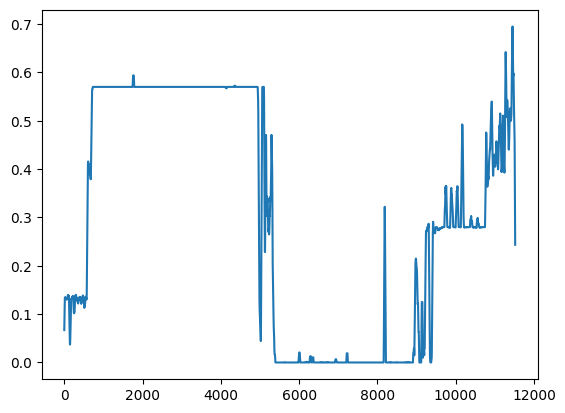

In [94]:
plt.plot(severity_trending_datas[:, 8])

In [64]:
pca = PCA(n_components=3)
data_pca = pca.fit_transform(severity_trending_datas)

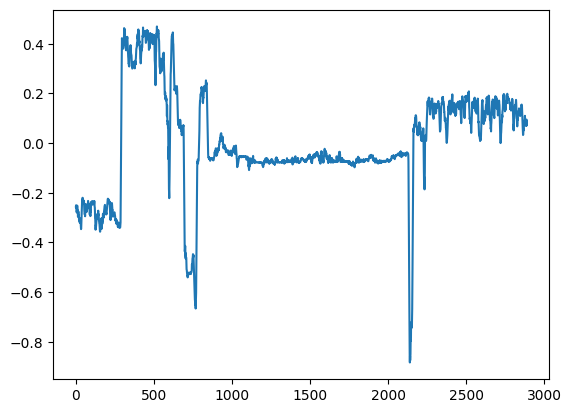

In [67]:
plt.plot(data_pca[:, 2])

In [72]:
current_trending.shape

(2985,)

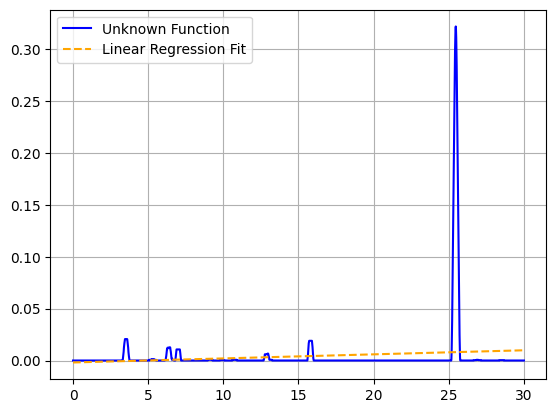

np.float64(0.00039198537900487026)

In [ ]:


current_trending = severity_trending_datas[:, 8] # 8 22
current_trending = np.convolve(current_trending, kernel, mode='same')

y = (current_trending - 0) / (100 - 0)
x = np.linspace(0, 30, len(y)).reshape(-1, 1) 

reg1 = LinearRegression()
reg1.fit(x, y)

y_linear1 = reg1.predict(x)

plt.plot(x, y, label="Unknown Function", color='blue')
plt.plot(x, y_linear1, label="Linear Regression Fit", linestyle="dashed", color='orange')
plt.legend()
plt.grid()
plt.show()

reg1.coef_[0]


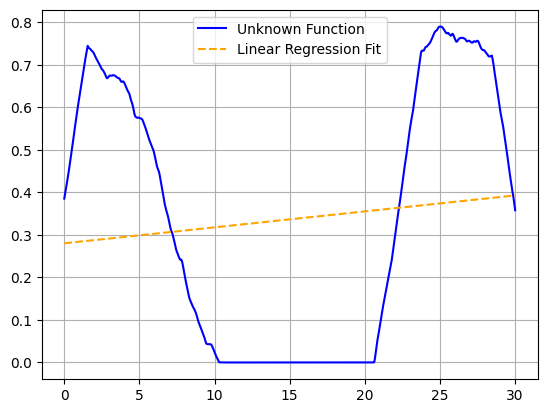

np.float64(0.003751953320932949)

In [35]:
reg1 = LinearRegression()
reg2 = LinearRegression()

x = np.linspace(0, 10, 100).reshape(-1, 1) 
y = (1 / (0.001 + np.exp(-(x - 5))))
y_rev = 1- (1 / (1 + np.exp(-(x - 5))))

reg1.fit(x, y)
reg2.fit(x, y_rev)

y_linear1 = reg1.predict(x)
y_linear2 = reg2.predict(x)

m1 = reg1.coef_[0]
m2 = reg2.coef_[0]

In [37]:
m1

array([6.77637505])

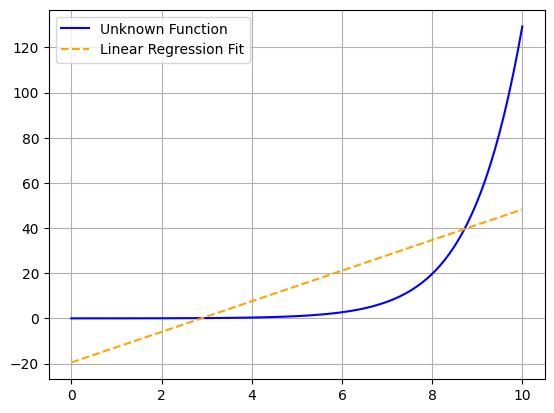

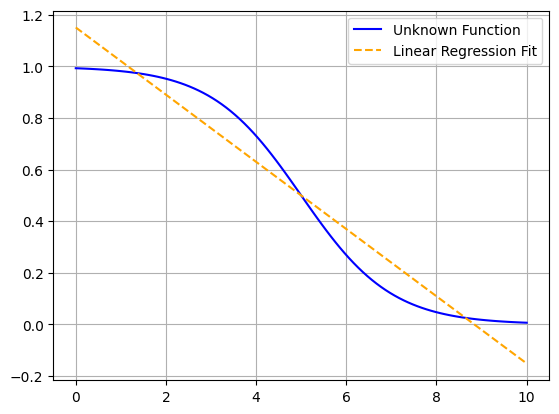

In [36]:
plt.plot(x, y, label="Unknown Function", color='blue')
plt.plot(x, y_linear1, label="Linear Regression Fit", linestyle="dashed", color='orange')
plt.legend()
plt.grid()
plt.show()

plt.plot(x, y_rev, label="Unknown Function", color='blue')
plt.plot(x, y_linear2, label="Linear Regression Fit", linestyle="dashed", color='orange')
plt.legend()
plt.grid()
plt.show()

In [31]:
reg1 = LinearRegression()
reg2 = LinearRegression()

x = np.linspace(0, 10, 100).reshape(-1, 1) 
y = 10 * x
y_rev = -10 * x

reg1.fit(x, y)
reg2.fit(x, y_rev)

y_linear1 = reg1.predict(x)
y_linear2 = reg2.predict(x)

m1 = reg1.coef_[0]
m2 = reg2.coef_[0]

In [32]:
m1

array([10.])

In [ ]:

reg.fit(x, y)  # Fit y = mx + b
m = reg.coef_[0]  # Extract slope (gradient)
b = reg.intercept_  # Extract intercept

# Compute predicted values from regression
y_linear = reg.predict(x)

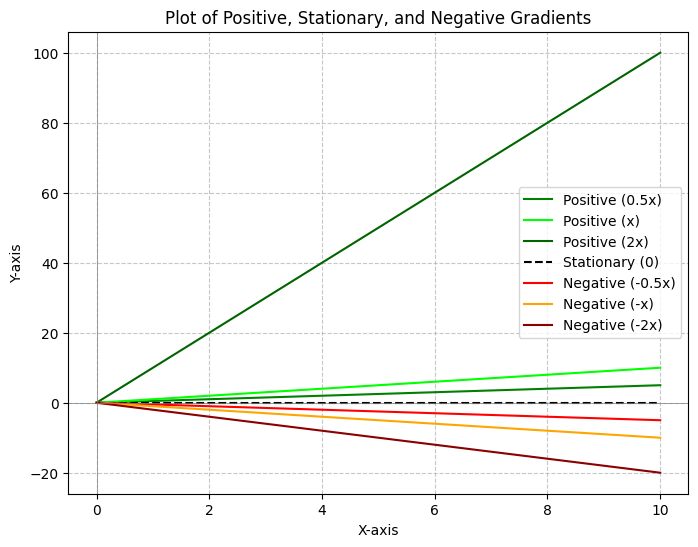

In [30]:
x = np.linspace(0, 10, 100)
positive_gradients = [0.5 * x, x, 10 * x]  # Increasing slopes
stationary_gradient = np.zeros_like(x)  # Flat line
negative_gradients = [-0.5 * x, -x, -2 * x]  # Decreasing slopes

# Define labels
labels = ['Positive (0.5x)', 'Positive (x)', 'Positive (2x)',
          'Stationary (0)',
          'Negative (-0.5x)', 'Negative (-x)', 'Negative (-2x)']

# Define colors
colors = ['green', 'lime', 'darkgreen', 'black', 'red', 'orange', 'darkred']

# Create the plot
plt.figure(figsize=(8, 6))

# Plot positive gradients
for i, y in enumerate(positive_gradients):
    plt.plot(x, y, label=labels[i], color=colors[i])

# Plot stationary gradient
plt.plot(x, stationary_gradient, label=labels[3], color=colors[3], linestyle='dashed')

# Plot negative gradients
for i, y in enumerate(negative_gradients, start=4):
    plt.plot(x, y, label=labels[i], color=colors[i])

# Customize plot
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.legend()
plt.title("Plot of Positive, Stationary, and Negative Gradients")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [23]:
import pickle
import os
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
import matplotlib.dates as mdates
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter

In [24]:
def percentage2severity(value):
    return (
        1 if 0 <= value < 5 else
        2 if 5 <= value < 20 else
        3 if 20 <= value < 40 else
        4 if 40 <= value < 75 else
        5 if 75 <= value <= 100 else
        6
    )
    
def calc_counterPercentage(threshold_percentages):
    counter_feature = {}
    for modex_idx, values_pred in threshold_percentages.items():
        values_pred = dict(sorted(values_pred.items(), key=lambda item: item[1], reverse=True)[:10])
        for name_feat, percentage in values_pred.items():
            if name_feat in counter_feature:
                counter_feature[name_feat]["count"] = counter_feature[name_feat]["count"] + 1
                counter_feature[name_feat]["percentage"] = counter_feature[name_feat]["percentage"] + percentage
            else:
                counter_feature[name_feat] = {"count": 1, "percentage": percentage}

    counter_feature_s1 = dict(sorted(counter_feature.items(), key=lambda item: item[1]['count'], reverse=True)[:10])
    counter_feature_s2 = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['percentage'] // len(model_array), reverse=True))
    #counter_feature_s2_rank = dict(sorted(counter_feature_s1.items(), key=lambda item: item[1]['count'], reverse=True))

    for key, value in counter_feature_s2.items():
        counter_feature_s2[key]['count'] = (counter_feature_s2[key]['count'] / len(model_array)) * 100
        counter_feature_s2[key]['severity'] = percentage2severity(counter_feature_s2[key]['percentage'] // len(model_array))
        counter_feature_s2[key]['percentage'] = (counter_feature_s2[key]['percentage'] // len(model_array))

    # Find Which Model Have Highest Confidence
    counter_feature_plot = {}
    for index, value in counter_feature_s2.items():
        higher_data = {"model": 0, "percentage": 0}
        for model_idx in threshold_percentages:
            if index in threshold_percentages[model_idx]:
                if higher_data["percentage"] <= threshold_percentages[model_idx][index]:
                    higher_data["model"] = model_idx
                    higher_data["percentage"] = threshold_percentages[model_idx][index]
        
        counter_feature_plot[index] = higher_data['model']

    return counter_feature_s2, counter_feature_plot

def calc_counterPercentageTrending(threshold_percentages):
    counter_feature = {}
    for modex_idx, values_pred in threshold_percentages.items():
        for name_feat, percentage in values_pred.items():
            if name_feat in counter_feature:
                if percentage > 5.0:
                    counter_feature[name_feat]["count"] = counter_feature[name_feat]["count"] + 1
                    counter_feature[name_feat]["percentage"] = counter_feature[name_feat]["percentage"] + percentage
            else:
                counter_feature[name_feat] = {"count": 1, "percentage": percentage}

    for key, value in counter_feature.items():
        counter_feature[key]['count'] = (counter_feature[key]['count'] / len(model_array)) * 100
        if counter_feature[key]['count'] >= 20.0:
            counter_feature[key]['severity'] = percentage2severity(counter_feature[key]['percentage'] // len(model_array))
            counter_feature[key]['percentage'] = (counter_feature[key]['percentage'] // len(model_array))
        else:
            counter_feature[key]['severity'] = 1
            counter_feature[key]['percentage'] = 0.0

    return counter_feature

def do_plotSeverityRank():
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(4, 3, figure=fig)

    feature_index_list = [feature_set.index(feat_name) for feat_name in list(counter_feature_s2.keys())]
    for idx, (feature_index_now) in enumerate(feature_index_list[:4]):
        model_idx_highest = counter_feature_plot[feature_set[feature_index_now]]

        ax = fig.add_subplot(gs[idx, :2])
        ax.plot(df_timestamp, temp_ypreds[model_idx_highest][:, feature_index_now], color='blue', label='Prediction')
        ax.plot(df_timestamp, df_feature[:, feature_index_now], color='red', label='Original')
        ax.set_title(feature_set[feature_index_now])
        ax.legend() 
        ax.grid(True)

    date_format = DateFormatter("%d/%m/%Y - %H:%M")  # Define the desired format
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()

    y2 = list(counter_feature_s2.keys())
    x2 = [value['severity'] for value in counter_feature_s2.values()]
    x2_c = [value['count'] for value in counter_feature_s2.values()]

    norm_x2 = [(val - 1) / 5 for val in x2]
    cmap = LinearSegmentedColormap.from_list('severity_colormap', ['green', 'yellow', 'red'])
    colors = [cmap(norm) for norm in norm_x2]

    ax3 = fig.add_subplot(gs[:3, 2])
    bars = ax3.barh(y2, x2, color=colors)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=6))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax3, orientation='vertical', label='Severity')

    for bar, perc in zip(bars, x2_c):
        width = bar.get_width()  # Get the width of the bar
        ax3.text(
            width - 0.1,             # X-coordinate (inside the bar, near the right edge)
            bar.get_y() + bar.get_height() / 2,  # Y-coordinate (center of the bar)
            f"{int(perc)}%",            # Text label (percentage with % sign)
            va='center',           # Vertical alignment
            ha='right',            # Horizontal alignment
            color='black',         # Text color for visibility
            fontsize=9            # Font size
        )
    ax3.invert_yaxis()
    ax3.set_xticks(range(1, 8))
    ax3.set_ylabel("Parameter")
    ax3.set_xlabel("Severity")
    ax3.set_title("Severity Rank")

    #fig.suptitle(f"{df_anomaly_unplaned.values[failure_index_list, 4]}_{df_anomaly_unplaned.values[failure_index_list, 0]}", fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    return fig


def fetch_between_dates(start_date, end_date, db_name="data.db", table_name="sensor_data"):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT * FROM {table_name} WHERE timestamp BETWEEN ? AND ?
    """, (start_date, end_date))
    
    rows = cursor.fetchall()
    conn.close()

    if not rows:
        return np.array([])
    
    return np.array(rows)

def convert_timestamp(timestamp_str):
    dt = datetime.fromisoformat(timestamp_str)
    return pd.Timestamp(dt.strftime('%Y-%m-%d %H:%M:%S'))



In [25]:
feature_set = ['Active Power', 'Reactive Power', 'Governor speed actual', 'UGB X displacement', 'UGB Y displacement',
    'LGB X displacement', 'LGB Y displacement', 'TGB X displacement',
    'TGB Y displacement', 'Stator winding temperature 13',
    'Stator winding temperature 14', 'Stator winding temperature 15',
    'Surface Air Cooler Air Outlet Temperature',
    'Surface Air Cooler Water Inlet Temperature',
    'Surface Air Cooler Water Outlet Temperature',
    'Stator core temperature', 'UGB metal temperature',
    'LGB metal temperature 1', 'LGB metal temperature 2',
    'LGB oil temperature', 'Penstock Flow', 'Turbine flow',
    'UGB cooling water flow', 'LGB cooling water flow',
    'Generator cooling water flow', 'Governor Penstock Pressure',
    'Penstock pressure', 'Opening Wicked Gate', 'UGB Oil Contaminant',
    'Gen Thrust Bearing Oil Contaminant']

# feature_set = ['Active Power', 'Governor speed actual', 
#     'UGB X displacement', 'UGB Y displacement', 'LGB X displacement', 'LGB Y displacement', 'TGB X displacement', 'TGB Y displacement', 
#     'Stator core temperature', 'Stator winding temperature 13', 'Stator winding temperature 14', 'Stator winding temperature 15',
#     'Surface Air Cooler Air Outlet Temperature', 'Surface Air Cooler Water Inlet Temperature', 'Surface Air Cooler Water Outlet Temperature',
#     'Gen Voltage Phase 1', 'Gen Voltage Phase 2', 'Gen Voltage Phase 3',
#     'Gen Current Phase 1', 'Gen Current Phase 2', 'Gen Current Phase 3', 
#     'UGB metal temperature', 'LGB metal temperature 1', 'LGB metal temperature 2',
#     'UGB oil temperature', 'LGB oil temperature', 'UGB cooling water flow', 'LGB cooling water flow', 'Generator cooling water flow',
#     'UGB Oil Contaminant', 'Gen Thrust Bearing Oil Contaminant',
#     'Penstock Flow', 'Turbine flow', 'Governor Penstock Pressure', 'Penstock pressure', 'Opening Wicked Gate']

model_array = ["Attention", "DTAAD", "MAD_GAN", "TranAD", "DAGMM", "USAD", "OmniAnomaly"]

# window_size = 15
# kernel = np.ones(window_size) / window_size

In [7]:
# conn = sqlite3.connect("db_data/original_data.db")
# cursor = conn.cursor()
# cursor.execute(f"""SELECT * FROM original_data order by rowid desc LIMIT 1""")
# rows = cursor.fetchall()
# conn.close()
# last_date = np.datetime64(np.array(rows)[:, 1][0]) 

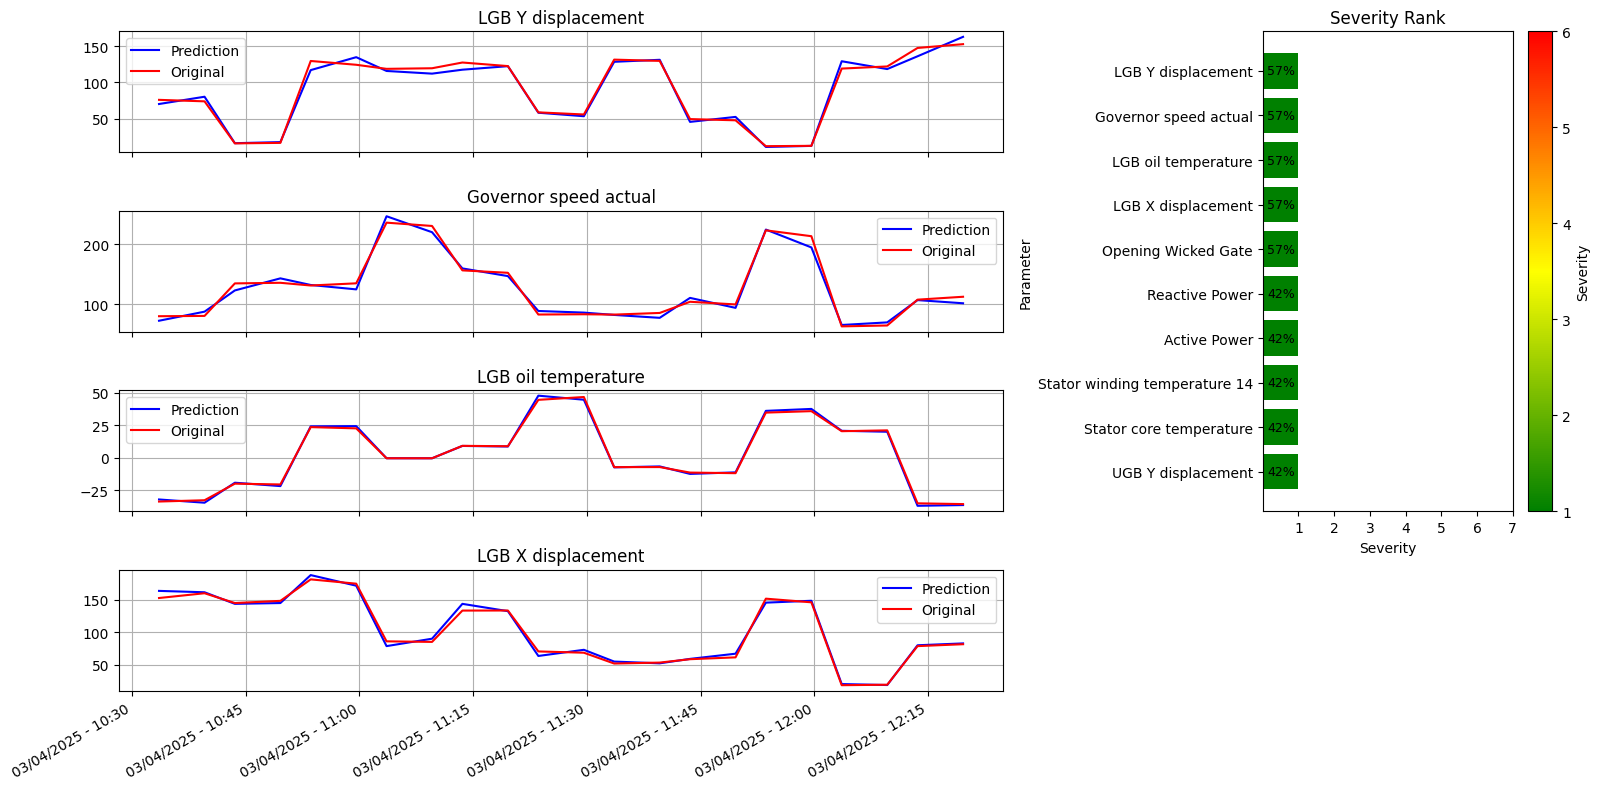

In [54]:
end_dates_lastest = datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%S") #"2025-03-27T05:36:00" 
timestamp = datetime.strptime(end_dates_lastest, "%Y-%m-%dT%H:%M:%S")
hours_2before = timestamp - timedelta(hours=2)
beofre_15min = timestamp - timedelta(minutes=60)
hours_2before_str = hours_2before.strftime("%Y-%m-%dT%H:%M:%S")

threshold_percentages = {}
for idx_model, (model_name) in enumerate(model_array):
    now_fetched = fetch_between_dates(beofre_15min.strftime("%Y-%m-%dT%H:%M:%S"), end_dates_lastest, "db/threshold_data.db", model_name)[-1, 2:]

    threshold_pass = {}
    for idx_sensor, sensor_thre in enumerate(now_fetched):
        threshold_pass[feature_set[idx_sensor]] = float(sensor_thre)

    threshold_percentages[idx_model] = threshold_pass

temp_original_data = fetch_between_dates(hours_2before_str, end_dates_lastest, "db/original_data.db", "original_data")
df_timestamp, df_feature = temp_original_data[:, 1], temp_original_data[:, 2:].astype(np.float16)
df_timestamp = np.array([convert_timestamp(now_str) for now_str in df_timestamp])

temp_ypreds = {}
for idx_model, (model_name) in enumerate(model_array):
    temp_ypreds[idx_model] = fetch_between_dates(hours_2before_str, end_dates_lastest, "db/pred_data.db", model_name)[:, 2:].astype(np.float16)

counter_feature_s2, counter_feature_plot = calc_counterPercentage(threshold_percentages)
df_feature_send = []
y_pred_send = []

feature_index_list = [feature_set.index(feat_name) for feat_name in list(counter_feature_s2.keys())]
for idx, (feature_index_now) in enumerate(feature_index_list[:4]):
    model_idx_highest = counter_feature_plot[feature_set[feature_index_now]]

    df_feature_send.append(temp_ypreds[model_idx_highest][:, feature_index_now])
    y_pred_send.append(df_feature[:, feature_index_now])

df_feature_send = np.vstack(df_feature_send).T
y_pred_send = np.vstack(y_pred_send).T

# To Send counter_feature_s2, df_feature_send, y_pred_send

fig = do_plotSeverityRank()

In [72]:
from sklearn.metrics import mean_squared_error

In [66]:
import torch.nn as nn

l = nn.MSELoss(reduction='none')

In [67]:
df_feature_send = []
y_pred_send = []
loss_send = []
thr_now_model = []

feature_index_list = [feature_set.index(feat_name) for feat_name in list(counter_feature_s2.keys())]
for idx, (feature_index_now) in enumerate(feature_index_list[:4]):
    model_idx_highest = counter_feature_plot[feature_set[feature_index_now]]

    df_feature_send.append(temp_ypreds[model_idx_highest][:, feature_index_now])
    y_pred_send.append(df_feature[:, feature_index_now])
    
    loss_send.append(df_feature[:, feature_index_now])
    thr_now_model.append(float(model_thr[model_array[model_idx_highest]][feature_index_now]))


# df_feature_send = np.vstack(df_feature_send).T
# y_pred_send = np.vstack(y_pred_send).T

array([121.    ,   2.25  ,   1.5625,  11.39  ,  43.88  ,   9.766 ,
        54.38  ,  24.38  , 107.6   ,   1.    ,  49.    ,  20.25  ,
         9.19  ,   1.266 ,   0.25  ,  32.    ,  37.5   ,   5.64  ,
         3.117 ,   0.2197,   1.723 ,   1.5625], dtype=float16)

In [70]:
temp_ypreds[model_idx_highest][:, feature_index_now]

array([164.  , 161.9 , 144.  , 145.2 , 188.4 , 172.  ,  78.8 ,  90.25,
       144.  , 132.8 ,  63.62,  73.1 ,  54.97,  52.28,  59.12,  67.1 ,
       145.9 , 148.8 ,  20.28,  18.8 ,  80.1 ,  83.  ], dtype=float16)

In [ ]:
l(, )

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [63]:
df_feature_send[0]

array([ 70.25,  80.3 ,  16.08,  17.56, 117.1 , 135.  , 115.94, 112.25,
       117.7 , 122.56,  58.2 ,  53.38, 128.6 , 131.4 ,  45.53,  52.44,
        10.86,  12.34, 129.4 , 118.56, 136.2 , 163.1 ], dtype=float16)

In [60]:
thr_now_model

[0.51412914030412,
 8.47902245290132e-05,
 0.00615947065991464,
 0.027637279112383183]

In [21]:
counter_feature = {}
for modex_idx, values_pred in threshold_percentages.items():
    values_pred = dict(sorted(values_pred.items(), key=lambda item: item[1], reverse=True)[:10])
    for name_feat, percentage in values_pred.items():
        if name_feat in counter_feature:
            counter_feature[name_feat]["count"] = counter_feature[name_feat]["count"] + 1
            counter_feature[name_feat]["percentage"] = counter_feature[name_feat]["percentage"] + percentage
        else:
            counter_feature[name_feat] = {"count": 1, "percentage": percentage}

counter_feature

{'Active Power': {'count': 7, 'percentage': 0.0},
 'Reactive Power': {'count': 7, 'percentage': 0.0},
 'Governor speed actual': {'count': 7, 'percentage': 0.0},
 'UGB X displacement': {'count': 7, 'percentage': 0.0},
 'UGB Y displacement': {'count': 7, 'percentage': 0.0},
 'LGB X displacement': {'count': 7, 'percentage': 0.0},
 'LGB Y displacement': {'count': 6, 'percentage': 0.0},
 'TGB X displacement': {'count': 6, 'percentage': 0.0},
 'TGB Y displacement': {'count': 6, 'percentage': 0.0},
 'Stator winding temperature 13': {'count': 2, 'percentage': 0.0},
 'Generator cooling water flow': {'count': 2,
  'percentage': 173.32999999999998},
 'LGB metal temperature 2': {'count': 1, 'percentage': 100.0},
 'UGB cooling water flow': {'count': 3, 'percentage': 294.15999999999997},
 'LGB cooling water flow': {'count': 1, 'percentage': 100.0},
 'Gen Thrust Bearing Oil Contaminant': {'count': 1, 'percentage': 30.0}}

In [22]:
counter_feature_s1 = dict(sorted(counter_feature.items(), key=lambda item: item[1]['count'], reverse=True)[:10])
counter_feature_s1

{'Active Power': {'count': 7, 'percentage': 0.0},
 'Reactive Power': {'count': 7, 'percentage': 0.0},
 'Governor speed actual': {'count': 7, 'percentage': 0.0},
 'UGB X displacement': {'count': 7, 'percentage': 0.0},
 'UGB Y displacement': {'count': 7, 'percentage': 0.0},
 'LGB X displacement': {'count': 7, 'percentage': 0.0},
 'LGB Y displacement': {'count': 6, 'percentage': 0.0},
 'TGB X displacement': {'count': 6, 'percentage': 0.0},
 'TGB Y displacement': {'count': 6, 'percentage': 0.0},
 'UGB cooling water flow': {'count': 3, 'percentage': 294.15999999999997}}

In [10]:
import scipy

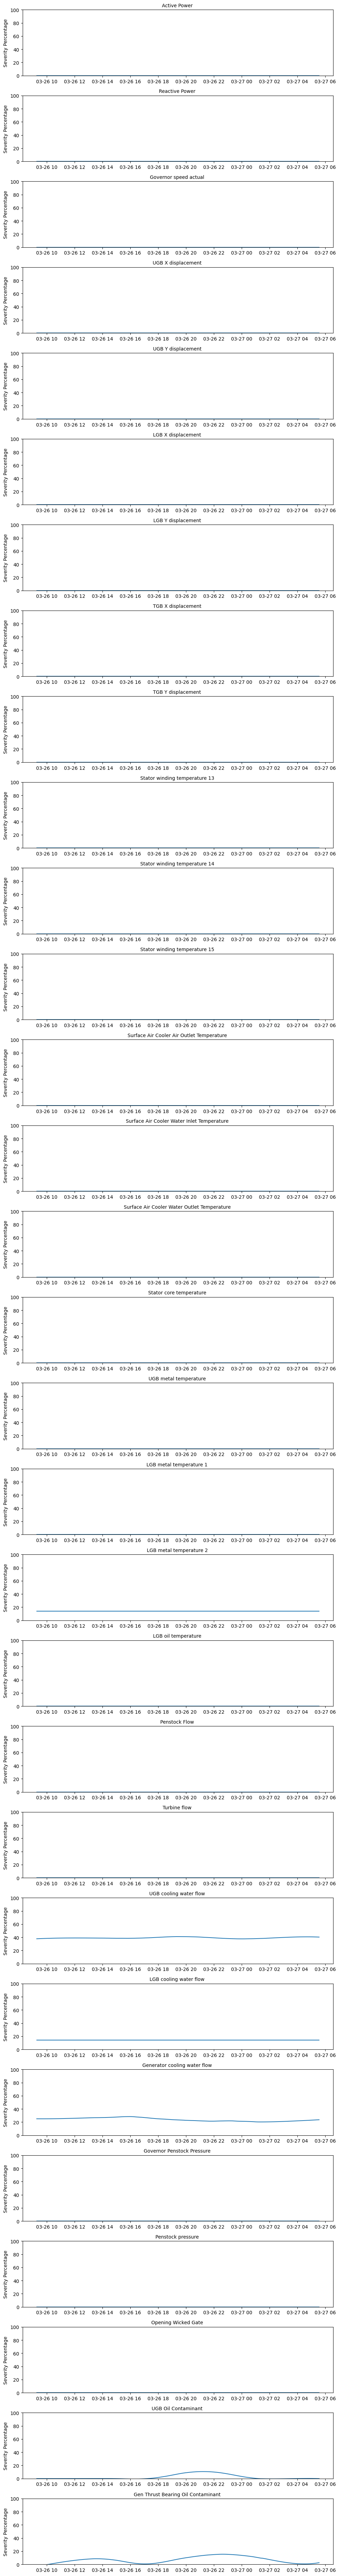

In [12]:
end_dates_lastest = "2025-03-27T05:36:00" 
timestamp = datetime.strptime(end_dates_lastest, "%Y-%m-%dT%H:%M:%S")
hours_2before = timestamp - timedelta(days=30)
hours_2before_str = hours_2before.strftime("%Y-%m-%dT%H:%M:%S")

data_between_dates = fetch_between_dates(hours_2before_str, end_dates_lastest, "db/severity_trendings.db", "severity_trendings")

data_feature = data_between_dates[:, 2:].astype(float)
data_timestamp = np.array([convert_timestamp(now_str) for now_str in data_between_dates[:, 1]])

fig, axes = plt.subplots(30, 1, figsize=(10, 75))
for i, ax in enumerate(axes):
    ax.plot(data_timestamp, scipy.signal.savgol_filter(data_feature[:, i], 50, 3))  # Plot data for each row
    ax.set_title(f'{feature_set[i]} ', fontsize=10)  # Set title
    #ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_ylim(0, 100)
    ax.set_ylabel("Severity Percentage")
    #ax.set_xticks(data_timestamp[::7])  # Reduce number of ticks

plt.tight_layout()
plt.show()

In [ ]:
# def denormalize3(a_norm, min_a, max_a):
#     return a_norm * (max_a - min_a + 0.0001) + min_a

# with open('normalize_2023.pickle', 'rb') as handle:
#     normalize_obj = pickle.load(handle)
#     min_a, max_a = normalize_obj['min_a'], normalize_obj['max_a']

# with open('model_thr.pickle', 'rb') as handle:
#     model_thr = pickle.load(handle)

# for model_now in model_array:
#     model_thr[model_now] = denormalize3(np.array(model_thr[model_now]), min_a, max_a).tolist()

# with open('model_thr.pickle', 'wb') as handle:
#     pickle.dump(model_thr, handle, protocol=pickle.HIGHEST_PROTOCOL)